In [620]:
#Finding Putative Binding Sites Using Motifs and then Visualize them

import twobitreader as tbr
import os
import time
import gzip
import shutil
import pandas as pd
import numpy as np
import re
from Bio import SeqIO
from itertools import islice
import matplotlib.pyplot as plt
import networkx as nx
import pygraphviz as pyg
import pydot

#path is a generic pfm path 
#Maybe expand to different motif formats
def read_pfm(path):
    pfm = []
    with open(path) as f:
        for line in f:
            if line.startswith('>'):
                continue
            elif re.match('^[A,C,T,G]', line):
                print('FileError: Wrong File Type')
            else:
                nuc_freqs = line.split()
                pfm.append(nuc_freqs)
    return np.asarray(pfm).astype(np.float)

#convert PFM to PWM
#bg is priors for all four nucleotides ACGT respectively
#pseudocount function for zero count positions
def pfm2pwm(pfm, pseudocount = 0.8, bg = [0.25, 0.25, 0.25, 0.25]):
    #chagnge into integer matrix
    pfm = np.trunc(pfm).astype(np.int)
    #Calculating Post Prob
    s = pseudocount
    bg_a = np.array(bg)
    bg_t = np.matrix(bg).transpose()
    N = np.sum(pfm[:,0])
    ppm = (pfm + (s*bg_t))/(N + s * np.sum(bg_a))
    #Calculate Weights
    norm_ppm = []
    for i in range(len(pfm)):
        norm = np.asarray(ppm[i]/(bg[i]/np.sum(bg_a))).reshape(-1)
        norm_ppm.append(norm.tolist())
    nppm = np.array(norm_ppm)
    pwm = np.log2(norm_ppm)
    return pwm

#Creating Reverese Complements
def reverseComp(Seq):
    seq = Seq.upper()
    d = {'A':'T', 'T':'A', 'G':'C', 'C':'G'}
    try:
        seq = seq[::-1]
        rc_seq = "".join([d[nuc] for nuc in seq])
    except KeyError:
        return "Not Viable DNA Seq"
    return rc_seq

#Search Sequence for sequence postion of DNA segments that match with a high enough score
def searchSeq(pwm, Seq, score, strand = '*', trim = 7):
    seqs = []
    pos_strand = Seq[trim:len(Seq)-trim]
    neg_strand = reverseComp(pos_strand)
    #Normalize PWM
    max_score = sum([max(i) for i in pwm.T])
    min_score = sum([min(i) for i in pwm.T])
    n = len(pwm[0])
    unitScale = (pwm-min_score/n)/(max_score-min_score)
    #Chunk sequence into overlapping segments
    if strand == '*':
        chunks = [pos_strand[i:i+n] for i in range(len(pos_strand)-n)]
        rev_chunks = [neg_strand[i:i+n] for i in range(len(neg_strand)-n)]
    for i in range(len(chunks)):
        OHESeq = oheSeq(chunks[i])
        OHErc = oheSeq(rev_chunks[i])
        posScore = sum([np.matmul(OHESeq[j], unitScale[:,j]) for j in range(n)])
        negScore = sum([np.matmul(OHErc[j], unitScale[:,j]) for j in range(n)])
        if posScore > score:
            seqs.append([chunks[i], posScore, i+1+trim,i+trim+n, '+'])
        if negScore > score:
            seqs.append([rev_chunks[i], negScore,len(Seq)-i-trim-n+1, len(Seq)-i-trim, '-'])
    seqs = np.array(seqs)
    if len(seqs) > 0:
        names = ['Sequence', 'Score','Start', 'End', 'Orient']
        return pd.DataFrame(seqs, columns=names)
    else:
        return seqs

#Parallelizable searchSeq for ChipSeq using UCSC 2bit reader
#If you are having errors involving indexing, make sure you are using the right organism and version of your genome
#revise with genseq (will reduce the program length immensely)
def searchPeaks(pwm, peak_path, twobitgenome, score, strand = '*', threads = 1):
    names = ['chrom', 'chromstart', 'chromend', 'numOfMatches', 'lenSeq']
    motifDF = []
    motifQuant = []
    if re.match('$fa',twobitgenome) or re.match('$fasta', twobitgenome):
        return 'Convert to 2bit: go to https://genome.ucsc.edu/goldenpath/help/twoBit.html for more info'
    genome = tbr.TwoBitFile(twobitgenome)
    if threads == 1:
        if bool(re.search('gz', peak_path)):
            with gzip.open(peak_path, 'rb') as f:
                for line in f:
                    line = line.decode('utf-8')
                    peak = list(line.split())
                    seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
        else:
            with open(peak_path) as f:
                for line in f:
                    peak = list(line.split())
                    seq = (genome[peak[0]][int(peak[1]):int(peak[2])]).upper()
                    try:
                        seqs = searchSeq(pwm, seq, score)
                    except KeyError:
                        continue
                    if len(seqs) > 0:
                        seqs['chrom'] = peak[0]
                        seqs['chromstart'] = peak[1]
                        seqs['chromend'] = peak[2]
                        motifDF.append(seqs)
                        motifQuant.append([peak[0], peak[1], peak[2], len(seqs), len(seq)])
    else:
        return "Not Ready Yet"
    return pd.concat(motifDF), pd.DataFrame(motifQuant, columns= names)

In [621]:
#Getting Cyp_Regulation Data from Rcode
cypRegTable = pd.read_csv('../data/cypRegTable.csv', sep = ',')
cypRegTable['seqLen'] = cypRegTable['dhs_end'] - cypRegTable['dhs_start']
#Trying to filter out DNA linker Regions from AtacSeq 
# Reference: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3125042/
cypRegTable = cypRegTable[cypRegTable['seqLen'] >= 100]
cypRegTable

,reg_gene,seq,dhs_chrom,dhs_start,dhs_end,de,seqLen
0,ENSG00000106258,TTCGCCTCGCCGGGTTCGGAACAGCAGGCTGGGATCAGCAACCATC...,chr7,99214440,99214590,1,150
1,ENSG00000130649,TGCCCAACTCCACTCTGTGGCAATGCCCTTCCCACCCATGGCACCC...,chr10,135278345,135278495,1,150
2,ENSG00000134716,CACGGGAGTGCAATGGTTACCATGGCATGCTTAATAGCGAGAGCAG...,chr1,60438360,60438510,1,150
3,ENSG00000134716,CACATTCCTTGGCTGTTGAGGAACTAATGAATTTCATGGAAACAGA...,chr1,60460660,60460810,1,150
4,ENSG00000138115,GCAGAGGACCAACAATGTGCTTCATGGAGAGAATTCCCATCCCACT...,chr10,96892820,96892970,1,150
5,ENSG00000140465,CTCCTTGTCACTGTTAAGAACAAAGAGAAAAACCAGATGGCATGAA...,chr15,74945880,74946030,1,150
6,ENSG00000140465,ACTCTAGCAGCCAAGGCAGAAGGTCTCACAGAATTCTCCAAACCAC...,chr15,74950380,74950530,1,150
7,ENSG00000140465,TTCCTCTCCCCAGAAGCCTTTTGACTCATCCAGCTGGCACAGCTTC...,chr15,75044980,75045130,1,150
8,ENSG00000140465,TTCTCCCCACTCCTTGTCAGCCTGGGCTCACAAGAAAGGCTGCCTG...,chr15,75082760,75082910,1,150
9,ENSG00000140465,TCGTTCATTCATTCATTCATTCAGCACTCATTTACTGAGCAGCCGC...,chr15,75083060,75083210,1,150


In [622]:
#Labeling Each Regulatory region
Regulatory_Names = []
DRE = 1
PRE = 1
for i in cypRegTable['de']:
    if i == 1:
        Regulatory_Names.append('DRE' + str(DRE))
        DRE += 1
    elif i == 0:
        Regulatory_Names.append('PRE' + str(PRE))
        PRE += 1
cypRegTable['names'] = Regulatory_Names
cypRegTable

,reg_gene,seq,dhs_chrom,dhs_start,dhs_end,de,seqLen,names
0,ENSG00000106258,TTCGCCTCGCCGGGTTCGGAACAGCAGGCTGGGATCAGCAACCATC...,chr7,99214440,99214590,1,150,DRE1
1,ENSG00000130649,TGCCCAACTCCACTCTGTGGCAATGCCCTTCCCACCCATGGCACCC...,chr10,135278345,135278495,1,150,DRE2
2,ENSG00000134716,CACGGGAGTGCAATGGTTACCATGGCATGCTTAATAGCGAGAGCAG...,chr1,60438360,60438510,1,150,DRE3
3,ENSG00000134716,CACATTCCTTGGCTGTTGAGGAACTAATGAATTTCATGGAAACAGA...,chr1,60460660,60460810,1,150,DRE4
4,ENSG00000138115,GCAGAGGACCAACAATGTGCTTCATGGAGAGAATTCCCATCCCACT...,chr10,96892820,96892970,1,150,DRE5
5,ENSG00000140465,CTCCTTGTCACTGTTAAGAACAAAGAGAAAAACCAGATGGCATGAA...,chr15,74945880,74946030,1,150,DRE6
6,ENSG00000140465,ACTCTAGCAGCCAAGGCAGAAGGTCTCACAGAATTCTCCAAACCAC...,chr15,74950380,74950530,1,150,DRE7
7,ENSG00000140465,TTCCTCTCCCCAGAAGCCTTTTGACTCATCCAGCTGGCACAGCTTC...,chr15,75044980,75045130,1,150,DRE8
8,ENSG00000140465,TTCTCCCCACTCCTTGTCAGCCTGGGCTCACAAGAAAGGCTGCCTG...,chr15,75082760,75082910,1,150,DRE9
9,ENSG00000140465,TCGTTCATTCATTCATTCATTCAGCACTCATTTACTGAGCAGCCGC...,chr15,75083060,75083210,1,150,DRE10


In [623]:
#Translate Ensembl codes to common name codes for genes
std_gene_names = ['CYP3A4','CYP2C9','CYP2C8','CYP2E1','CYP1A2','CYP2A6','CYP2D6','CYP2B6','CYP2C19','CYP3A5','CYP2J2','CYP1A1','CYP1B1']
ensmbl_names = ['ENSG00000160868','ENSG00000138109','ENSG00000138115','ENSG00000130649','ENSG00000140505','ENSG00000255974','ENSG00000100197','ENSG00000197408','ENSG00000165841','ENSG00000106258','ENSG00000134716','ENSG00000140465','ENSG00000138061']
print(len(std_gene_names), len( ensmbl_names))
gene_translate = {}
for i in range(len(ensmbl_names)):
    gene_translate[ensmbl_names[i]] = std_gene_names[i]

13 13


In [624]:
#Write regulatory regions to csv file to be read by pybedtools
reg_bed = pd.DataFrame({'chr':cypRegTable['dhs_chrom'],'start':cypRegTable['dhs_start'], 'end':cypRegTable['dhs_end'], 'name':cypRegTable['names']})
reg_bed.to_csv('../data/regelements.bed', sep = '\t', header = False, index = False)

In [625]:
from pybedtools import BedTool

In [626]:
#Load Bed Files as Bedtool instances
regBed = BedTool('../data/regelements.bed')
ahrBed = BedTool('../data/liver_euchormatin/Sudin_Data_AHR.bed')
pparaBed = BedTool('../data/liver_euchormatin/Sudin_Data_PPARa.bed')
cepbpbBed = BedTool('../data/liver_euchormatin/ENCFF319IEF_Hg19_HepG2_Chip_CEBPB.bed.gz')
hnf1aBed = BedTool('../data/liver_euchormatin/ENCFF227PWE_Hg19_HepG2_Chip_HNF1A.bed.gz')
foxa1Bed = BedTool('../data/liver_euchormatin/ENCFF675TLS_Hg19_HepG2_Chip_FOXA1.bed.gz')
hnf4aBed = BedTool('../data/liver_euchormatin/ENCFF884JKW_Hg19_HepG2_Chip_HNF4A.bed.gz')
bedfiles = [ahrBed, pparaBed, cepbpbBed, hnf1aBed, foxa1Bed, hnf4aBed]

In [628]:
#Get the intersection of the regulatory reigions and the bed files of the ChIP-Seq Data
tf = ['AHR', 'PPARA', 'CEBPB', 'HNF1A', 'FOXA1', 'HNF4A']
tf_assoc = pd.DataFrame(columns=['Regulatory Element', 'tf'])
for b in range(len(bedfiles)):
    b_inter = [str(i).split() for i in regBed.intersect(bedfiles[b])]
    b_df = pd.DataFrame(b_inter, columns=['chr', 'start', 'end', 'name'])
    b_assoc = pd.DataFrame({'Regulatory Element':b_df['name'], 'tf':[tf[b]]*len(b_df)})
    tf_assoc = pd.concat([tf_assoc, b_assoc])

0
1
2
3
4
5


In [ ]:
#Plot Frequency plot
print(freqs[:10])
plt.plot(range(70,100), freqs)
plt.show()

In [ ]:
#Finding crude "Knee" of graph to find 
#Code courtesy of Jonas (original) and rafelle valle 
# https://stackoverflow.com/questions/2018178/finding-the-best-trade-off-point-on-a-curve
import numpy as np
from numpy import matlib
nPoints = len(freqs)
allCoord = np.vstack((range(80,100), freqs)).T
np.array([range(80,100), freqs])
firstPoint = allCoord[0]
lineVec = allCoord[-1] - allCoord[0]
lineVecNorm = lineVec / np.sqrt(np.sum(lineVec**2))
vecFromFirst = allCoord - firstPoint
scalarProduct = np.sum(vecFromFirst * matlib.repmat(lineVecNorm, nPoints, 1), axis=1)
vecFromFirstParallel = np.outer(scalarProduct, lineVecNorm)
vecToLine = vecFromFirst - vecFromFirstParallel
distToLine = np.sqrt(np.sum(vecToLine ** 2, axis=1))
idxOfBestPoint = np.argmax(distToLine)
print(range(80,100)[idxOfBestPoint], freqs[idxOfBestPoint])

In [629]:
#Finding Putatative Transcription Factor binding sites using "optimized" threshold
import os
tfdir = '../data/cypRegMotifs/'
tf = []
for i in os.listdir(tfdir):
    pwm = read_pfm(tfdir + i)
    tf.append([pwm.T ,i])
tf = pd.DataFrame(tf, columns=['pwm', 'tf'])
names = ['Sequence', 'Score','Start', 'End', 'Orient', 'TF', 'DEorPP', 'reg_gene', 'chr', 'start_coord', 'end_coord', 'names']
testSeqs = pd.DataFrame(columns=names)
for TF in range(len(tf)):
    for j in range(len(cypRegTable['seq'])):
        seqs = searchSeq(tf.iloc[TF, 0], cypRegTable.iloc[j, 1], 0.8)
        if len(seqs) > 0:
            seqs['TF'] = tf.iloc[TF, 1]
            seqs['DEorPP'] = cypRegTable.iloc[j, 5]
            seqs['reg_gene'] = cypRegTable.iloc[j, 0]
            seqs['chr'] = cypRegTable.iloc[j, 2]
            seqs['start_coord'] = cypRegTable.iloc[j, 3] + seqs['Start'].values.astype('int')
            seqs['end_coord'] = cypRegTable.iloc[j, 3] + seqs['End'].values.astype('int')
            seqs['names'] = cypRegTable.iloc[j,-1]
            testSeqs = testSeqs.append(seqs)
testSeqs['DEorPP'][testSeqs['DEorPP'] == 1] = 'DE'
testSeqs['DEorPP'][testSeqs['DEorPP'] == 0] = 'PP'
testSeqs['TF'][testSeqs['TF'] == 'NR1I3_HUMAN.H11MO.0.C.pwm'] = 'CAR'
testSeqs['TF'][testSeqs['TF'] == 'NR1I2_HUMAN.H11MO.0.C.pwm'] = 'PXR'
testSeqs

,Sequence,Score,Start,End,Orient,TF,DEorPP,reg_gene,chr,start_coord,end_coord,names
0,AAAGTCAACAAACTCCGT,0.8014539126241796,113,130,+,CAR,DE,ENSG00000134716,chr1,60460773,60460790,DRE4
0,AATGTCAAGAGAGTTAGT,0.8299266207252306,108,125,+,CAR,DE,ENSG00000140465,chr15,75045088,75045105,DRE8
0,GGGGTTAGAGCAGGCTAA,0.8098841382152923,47,64,-,CAR,DE,ENSG00000140505,chr15,75081387,75081404,DRE24
0,TGAGTCAGTCGAGGTTTT,0.8181225697385344,22,39,-,CAR,PP,ENSG00000165841,chr10,96440377,96440394,PRE21
0,GGGCTCCACCCAGTTCAA,0.8395552055203169,54,71,+,CAR,PP,ENSG00000165841,chr10,96617929,96617946,PRE22
0,ATGAATGATTAAAGCTCAG,0.804651911305308,51,69,+,PXR,PP,ENSG00000130649,chr10,135332106,135332124,PRE3
0,AGGGATTATGTAAAGTCAG,0.8090491852204564,82,100,-,PXR,PP,ENSG00000160868,chr7,99370397,99370415,PRE20
0,TGGGCTCCACCCAGTTCAA,0.8841286956922003,53,71,+,PXR,PP,ENSG00000165841,chr10,96617928,96617946,PRE22


In [644]:
#Write nodes and edges to networkx graph instance
assoc = pd.DataFrame({'Regulatory Element':cypRegTable['names'], 'Association':[gene_translate[i] for i in cypRegTable['reg_gene']]})
G = nx.Graph()
for i in std_gene_names:
    G.add_node(i)
for i in Regulatory_Names:
    G.add_node(i[0])
for x,y in assoc.values:
    G.add_edge(x,y)
for i in tf:
    G.add_node(i)
for x,y in tf_assoc.values[1:]:
    G.add_edge(x,y)
motif_assoc = pd.DataFrame({'Regulatory Element':testSeqs['names'], 'Association':testSeqs['TF']})
G.add_node('CAR')
G.add_node('PXR')
for x,y in motif_assoc.values:
    G.add_edge(x,y)

In [645]:
# Creating lists for labels when drawing the graph
reglist = assoc['Regulatory Element'].values.tolist() + tf_assoc['Regulatory Element'].values.tolist()
PRs = [k for k in reglist if 'PR' in k]
DRs = [k for k in reglist if 'DR' in k]

['PRE1',
 'PRE2',
 'PRE3',
 'PRE4',
 'PRE5',
 'PRE6',
 'PRE7',
 'PRE8',
 'PRE9',
 'PRE10',
 'PRE11',
 'PRE12',
 'PRE13',
 'PRE14',
 'PRE15',
 'PRE16',
 'PRE17',
 'PRE18',
 'PRE19',
 'PRE20',
 'PRE21',
 'PRE22',
 'PRE7',
 'PRE8',
 'PRE9',
 'PRE10',
 'PRE11',
 'PRE13',
 'PRE14',
 'PRE15',
 'PRE16',
 'PRE17',
 'PRE18',
 'PRE19',
 'PRE5',
 'PRE13',
 'PRE20',
 'PRE21',
 'PRE1',
 'PRE2',
 'PRE19',
 'PRE20',
 'PRE21',
 'PRE19',
 'PRE1',
 'PRE4',
 'PRE5',
 'PRE14',
 'PRE18',
 'PRE19',
 'PRE20']

In [646]:
#Remove unused nodes 
G.remove_node('P')
G.remove_node('D')
G.remove_node('CYP2C9')
G.remove_node('CYP2D6')
G.remove_node('CYP2B6')
G.remove_node('pwm')
G.remove_node('tf')

In [743]:
#Shorten lables for genes
labels = {}
for i in G.nodes():
    if 'DR' not in i and 'PR' not in i:
        if 'CYP' in i:
            labels[i] = i[-3:]
        else:
            labels[i] = i
labels

{'CYP3A4': '3A4',
 'CYP2C8': '2C8',
 'CYP2E1': '2E1',
 'CYP1A2': '1A2',
 'CYP2A6': '2A6',
 'CYP2C19': 'C19',
 'CYP3A5': '3A5',
 'CYP2J2': '2J2',
 'CYP1A1': '1A1',
 'CYP1B1': '1B1',
 'AHR': 'AHR',
 'PPARA': 'PPARA',
 'CEBPB': 'CEBPB',
 'HNF1A': 'HNF1A',
 'FOXA1': 'FOXA1',
 'HNF4A': 'HNF4A',
 'CAR': 'CAR',
 'PXR': 'PXR'}

In [648]:
import matplotlib.lines as mlines

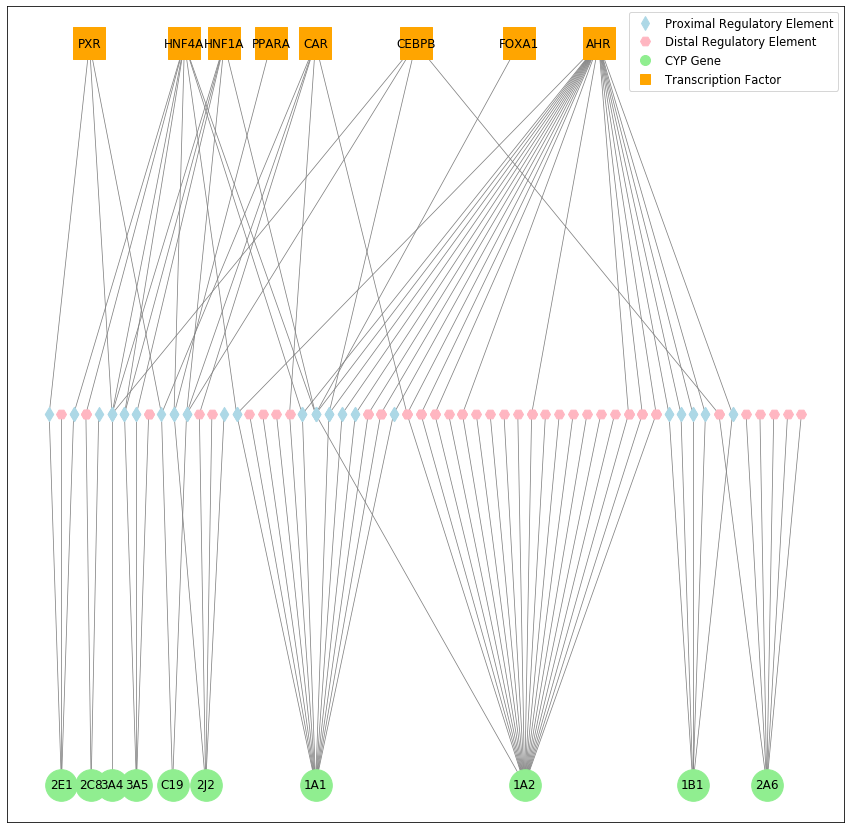

In [758]:
#Setting up figure
fig = plt.figure(figsize=[15,15])
ax = fig.add_subplot(111)
tf = ['AHR', 'PPARA', 'CEBPB', 'HNF1A', 'FOXA1', 'HNF4A', 'CAR', 'PXR']

#Postioning Nodes
pos = nx.drawing.nx_agraph.graphviz_layout(G, 'dot')
pos2 = {}
for i in pos:
    if 'CYP'in i:
        pos2[i] = (pos[i][0], pos['AHR'][1])
    elif 'PR' in i or 'DR' in i:
        pos2[i] = pos[i]
    else:
        pos2[i] = (pos[i][0]*1.75, pos['CYP3A4'][1])
pos = pos2
pos2['PXR'] = (pos2['PXR'][0]-500, pos2['PXR'][1])
pos2['HNF1A'] = (pos2['HNF1A'][0]+100, pos2['PXR'][1])
pos2['AHR'] = (pos2['AHR'][0]-800, pos2['AHR'][1])
#Drawing Nodes
nx.draw_networkx_nodes(G, pos,
                       nodelist=set(assoc['Association'].values),
                       node_color='lightgreen',
                      node_size = 1000)
nx.draw_networkx_nodes(G, pos,
                       nodelist= tf,
                      node_color='orange',
                      node_shape = 's',
                      node_size = 1000)
nx.draw_networkx_nodes(G, pos,
                      nodelist = PRs,
                       node_color='lightblue',
                      node_shape='d',
                      node_size =100)    
nx.draw_networkx_nodes(G, pos,
                      nodelist = DRs,
                       node_color='lightpink',
                      node_shape='H',
                      node_size =100)
#Draw edges
nx.draw_networkx_edges(G, pos, edge_color='gray', width = 0.75)

#Draw Labels 
nx.draw_networkx_labels(G, pos, labels = labels)

#Creating Custom Legends
purple_triangle = mlines.Line2D([], [], color='lightblue', marker='d', linestyle='None',
                          markersize=10, label='Proximal Regulatory Element')
red_triangle = mlines.Line2D([], [], color='lightpink', marker='H', linestyle='None',
                          markersize=10, label='Distal Regulatory Element')
green_triangle = mlines.Line2D([], [], color='lightgreen', marker='o', linestyle='None',
                          markersize=10, label='CYP Gene')
yellow_triangle = mlines.Line2D([], [], color='orange', marker='s', linestyle='None',
                          markersize=10, label='Transcription Factor')

plt.legend(handles = [purple_triangle, red_triangle, green_triangle, yellow_triangle], prop = {'size':11.5})

#Save and Show Figure
plt.savefig('../figs/cytoproto.png')
plt.show()

In [422]:
# Getting genomic coordinates of interest
gene_locs = pd.read_csv('../data/cypRegGeneLocs.txt', sep=',')
#creating vanilla text objects for circos 
gen_texts = pd.DataFrame(columns=['chr', 'start', 'end', 'gene'])
gen_texts['chr'] = ['hs' + str(i) for i in gene_locs['chromosome_name']]
gen_texts['start'] = gene_locs['start_position']
gen_texts['end'] = gene_locs['end_position']
gen_texts['gene'] = gene_locs['hgnc_symbol']

gen_texts
gen_texts.to_csv('../data/cypRegGenetext.txt', sep='\t',header = False, index = False)

In [729]:
#Creating links file for circos
cypRegTable['hgnc_symbol'] = [gene_translate[i] for i in cypRegTable['reg_gene']]
names = ['chr', 'start', 'end', 'gen_chr', 'gen_start', 'gen_end']
links = pd.DataFrame(columns=names)
links['chr'] = cypRegTable['dhs_chrom']
links['start'] = cypRegTable['dhs_start']
links['end'] = cypRegTable['dhs_end']
links['gen_chr'] = [gene_locs['chromosome_name'][gene_locs['ensembl_gene_id'] ==  i].values[0] for i in cypRegTable['reg_gene']]
links['gen_start'] = [gene_locs['start_position'][gene_locs['ensembl_gene_id'] ==  i].values[0] for i in cypRegTable['reg_gene']]
links['gen_end'] = [gene_locs['end_position'][gene_locs['ensembl_gene_id'] ==  i].values[0] for i in cypRegTable['reg_gene']]
links['chr']  = ['hs' + i[3:] for i in links['chr']]
links['gen_chr'] = ['hs' + str(i) for i in links['gen_chr']]
links.to_csv('../data/cypRegLinks.txt', sep='\t',header = False, index = False)